## 1. data visualization

In [1]:
# prepare libraries, although we can only use torch in the end, we need the others for to check the data first 
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch import optim

In [2]:
#load dataset
noisy_imgs_1 , noisy_imgs_2 = torch.load(r'C:\Users\huang\Desktop\DeepLearning\drive-download-20220428T201202Z-001\train_data.pkl')
noisy_imgs, clean_imgs = torch.load(r'C:\Users\huang\Desktop\DeepLearning\drive-download-20220428T201202Z-001\val_data.pkl')

In [3]:
#data is 50'000 imgs, per 3 channel per 32x32 pixels
print(noisy_imgs_1.size())
print(noisy_imgs_2.size())

torch.Size([50000, 3, 32, 32])
torch.Size([50000, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1.) tensor(0.0078)
tensor(1.) tensor(0.)
tensor(1.) tensor(0.0353)
tensor(0.9098) tensor(0.1255)


Text(0.5, 1.0, 'difference test')

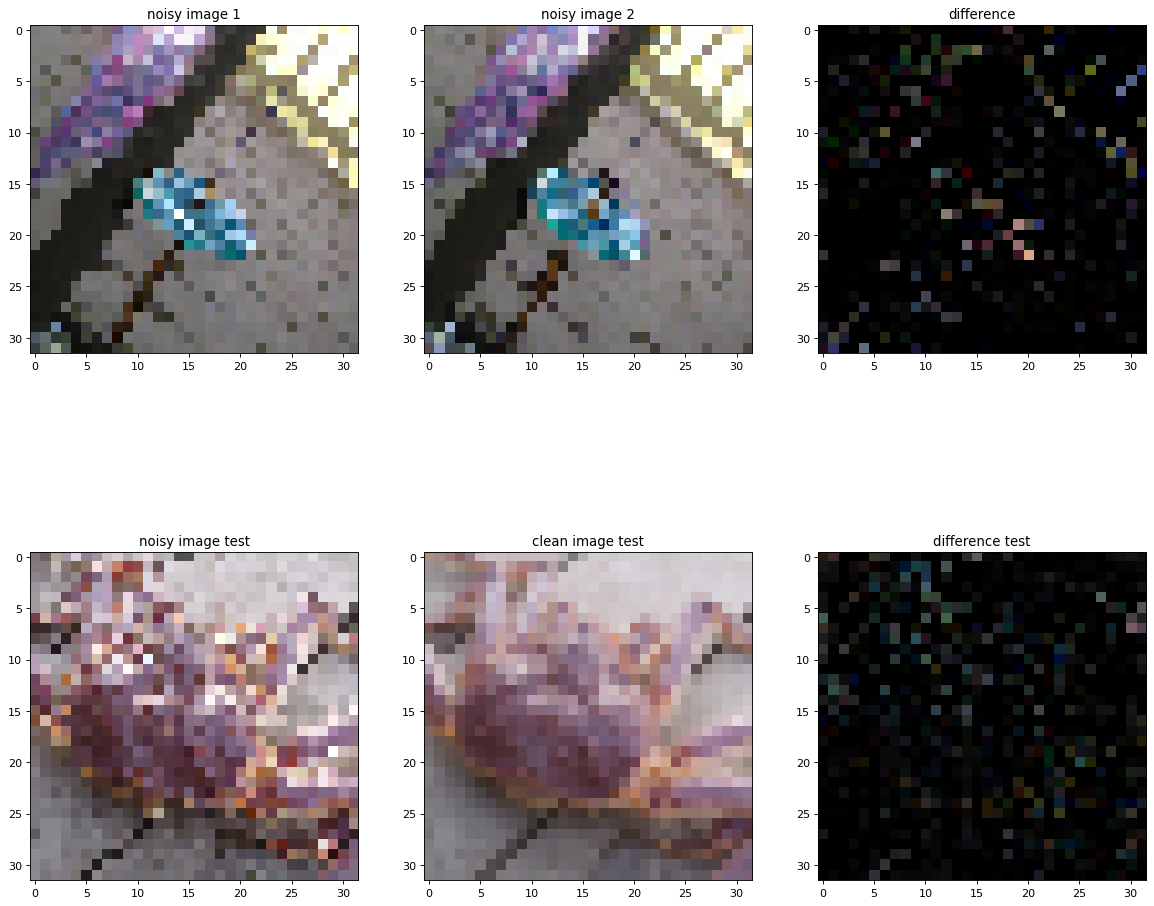

In [5]:
# initialize noisy data
noisy_imgs_1, noisy_imgs_2 = noisy_imgs_1.float(), noisy_imgs_2.float()
noisy_imgs, clean_imgs = noisy_imgs.float(), clean_imgs.float()

# in case you want to standardize
def standardize_data(data):
    mean,std = data.mean(), data.std()
    # normalize only if it wasn't done in a previous run of the notebook
    if mean > 0.001:
        data = data.sub_(mean).div_(std)
    return data

# In case you want to normalize :
def normalize_data(data):
    division = data.max().sub_(data.min())
    output = data.sub_(data.min()).div_(division)
#     print(data.max())
#     print(data.min())
    return data

# normalize the values of the images
noisy_imgs_1, noisy_imgs_2 = normalize_data(standardize_data(noisy_imgs_1)), normalize_data(standardize_data(noisy_imgs_2))
noisy_imgs, clean_imgs = normalize_data(standardize_data(noisy_imgs)), normalize_data(standardize_data(clean_imgs))

# Plot a few images to see the dataset we have. and what kind of noise we do have to put the channel at the end thought
plt.figure(figsize=(18, 16), dpi=80)

plt.subplot(2,3,1)
plt.imshow(noisy_imgs_1[0].permute(1, 2, 0));plt.title('noisy image 1')
print(noisy_imgs_1[0].max(),noisy_imgs_1[0].min())

plt.subplot(2,3,2)
plt.imshow(noisy_imgs_2[0].permute(1, 2, 0));plt.title('noisy image 2')
print(noisy_imgs_2[0].max(),noisy_imgs_2[0].min())

plt.subplot(2,3,3)
plt.imshow(noisy_imgs_2[0].permute(1, 2, 0)-noisy_imgs_1[0].permute(1, 2, 0));plt.title('difference')

plt.subplot(2,3,4)
plt.imshow(noisy_imgs[0].permute(1, 2, 0));plt.title('noisy image test')
print(noisy_imgs[0].max(),noisy_imgs[0].min())

plt.subplot(2,3,5)
plt.imshow(clean_imgs[0].permute(1, 2, 0));plt.title('clean image test')
print(clean_imgs[0].max(),clean_imgs[0].min())

plt.subplot(2,3,6)
plt.imshow(clean_imgs[0].permute(1, 2, 0)-noisy_imgs[0].permute(1, 2, 0));plt.title('difference test')

## 2. PSNR function

In [6]:
### definition of the loss function used from our informations, pnsr is our metric for accuracy in this scenario
def psnr(denoised, ground_truth):
    # Peak Signal to Noise Ratio : denoised and ground_truth have range [0,1]
    mse = torch.mean((denoised - ground_truth) ** 2)
    return -10* torch.log10(mse + 10**-8)

print(psnr(noisy_imgs,clean_imgs))
print(psnr(noisy_imgs_1,noisy_imgs_2))

tensor(19.6150)
tensor(16.6161)


In [7]:
# definition of the loss function which can be found online, another version similar to the first version
def psnr_v2(denoised, ground_truth):
    
    mse = torch.mean((denoised - ground_truth) ** 2)
    return 20* torch.log10(torch.max(denoised)) - 10*torch.log10(mse + 10**-8)
# note that if the max is = 1, then the log gives, 0 which gives the formula from the professor before.
# the 10**-8 is in case mse = 0 as log of 0 is not defined

print(psnr_v2(noisy_imgs,clean_imgs))
print(psnr_v2(noisy_imgs_1,noisy_imgs_2))

tensor(19.6150)
tensor(16.6161)


## 3. Initial model

In [8]:
# define the Noise2Noise algorithm here, it's structure, and construction.
class Noise2Noise(nn.Module):
    """Custom U-Net architecture for Noise2Noise (see Appendix, Table 2)."""

    def __init__(self, in_channels=3, out_channels=3):
        """Initializes U-Net."""

        super().__init__()
        self.conv11 = nn.Conv2d(3, 48, 3, stride=1, padding=1)
        self.bn11 = nn.BatchNorm2d(48)
        self.conv12 = nn.Conv2d(48, 48, 3, stride=1, padding=1)
        self.bn12 = nn.BatchNorm2d(48)

        self.conv2 = nn.Conv2d(48, 48, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(48)

        self.conv3 = nn.Conv2d(48, 48, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(48)

        self.conv4 = nn.Conv2d(48, 48, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(48)

        self.conv5 = nn.Conv2d(48, 48, 3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(48)

        self.conv6 = nn.Conv2d(48, 48, 3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(48)

        self.deconv11 = nn.ConvTranspose2d(96, 96, 3, stride=1, padding=1)
        self.bn_11 = nn.BatchNorm2d(96)

        self.deconv12 = nn.ConvTranspose2d(96, 96, 3, stride=1, padding=1)
        self.bn_12 = nn.BatchNorm2d(96)

        self.deconv21 = nn.ConvTranspose2d(144, 96, 3, stride=1, padding=1)
        self.bn_21 = nn.BatchNorm2d(96)

        self.deconv22 = nn.ConvTranspose2d(96, 96, 3, stride=1, padding=1)
        self.bn_22 = nn.BatchNorm2d(96)

        self.deconv31 = nn.ConvTranspose2d(144, 96, 3, stride=1, padding=1)
        self.bn_31 = nn.BatchNorm2d(96)

        self.deconv32 = nn.ConvTranspose2d(96, 96, 3, stride=1, padding=1)
        self.bn_32 = nn.BatchNorm2d(96)

        self.deconv41 = nn.ConvTranspose2d(144, 96, 3, stride=1, padding=1)
        self.bn_41 = nn.BatchNorm2d(96)

        self.deconv42 = nn.ConvTranspose2d(96, 96, 3, stride=1, padding=1)
        self.bn_42 = nn.BatchNorm2d(96)

        self.deconv51 = nn.ConvTranspose2d(99, 64, 3, stride=1, padding=1)
        self.bn_51 = nn.BatchNorm2d(64)

        self.deconv52 = nn.ConvTranspose2d(64, 32, 3, stride=1, padding=1)
        self.bn_52 = nn.BatchNorm2d(32)

        self.deconv53 = nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1)
        self.bn_53 = nn.BatchNorm2d(3)

    # initialize the weights of the model based on a research paper
    def _init_weights(self):
        """Initializes weights using He et al. (2015)."""

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.zero_()
    
    # define the forward pass of the model
    def forward(self, x):
        """Through encoder, then decoder by adding U-skip connections. """

        # Encoder
        x1 = F.leaky_relu(self.bn11(self.conv11(x)),0.1)
        x1 = F.leaky_relu(self.bn12(self.conv12(x1)),0.1)
        x1 = F.max_pool2d(x1, kernel_size=2, stride=2)

        x2 = F.leaky_relu(self.bn2(self.conv2(x1)),0.1)
        x2 = F.max_pool2d(x2, kernel_size=2, stride=2)
        
        x3 = F.leaky_relu(self.bn3(self.conv3(x2)),0.1)
        x3 = F.max_pool2d(x3, kernel_size=2, stride=2)

        x4 = F.leaky_relu(self.bn4(self.conv4(x3)),0.1)
        x4 = F.max_pool2d(x4, kernel_size=2, stride=2)
        
        x5 = F.leaky_relu(self.bn5(self.conv5(x4)),0.1)
        x5 = F.max_pool2d(x5, kernel_size=2, stride=2)
        
        x6 = F.leaky_relu(self.bn6(self.conv6(x5)),0.1)
        x6 = nn.Upsample(scale_factor=(2,2), mode='nearest')(x6)
        
        x7 = torch.cat((x6, x4), dim=1)
        
        x8 = F.leaky_relu(self.bn_11(self.deconv11(x7)),0.1)
        x8 = F.leaky_relu(self.bn_12(self.deconv12(x8)),0.1)
        x8 = nn.Upsample(scale_factor=(2,2), mode='nearest')(x8)
        x8 = torch.cat((x8, x3), dim=1)
        
        x9 = F.leaky_relu(self.bn_21(self.deconv21(x8)),0.1)
        x9 = F.leaky_relu(self.bn_22(self.deconv22(x9)),0.1)
        x9 = nn.Upsample(scale_factor=(2,2), mode='nearest')(x9)
        x9 = torch.cat((x9, x2), dim=1)
        
        x10 = F.leaky_relu(self.bn_31(self.deconv31(x9)),0.1)
        x10 = F.leaky_relu(self.bn_32(self.deconv32(x10)),0.1)
        x10 = nn.Upsample(scale_factor=(2,2), mode='nearest')(x10)
        x10 = torch.cat((x10, x1), dim=1)
        
        x11 = F.leaky_relu(self.bn_41(self.deconv41(x10)),0.1)
        x11 = F.leaky_relu(self.bn_42(self.deconv42(x11)),0.1)
        x11 = nn.Upsample(scale_factor=(2,2), mode='nearest')(x11)
        x11 = torch.cat((x11, x), dim=1)
        
        x12 = F.leaky_relu(self.bn_51(self.deconv51(x11)),0.1)
        x12 = F.leaky_relu(self.bn_52(self.deconv52(x12)),0.1)
        x12 = F.sigmoid(self.bn_53(self.deconv53(x12)))

        return x12


In [9]:
# function to train the Noise2Noise model
def train_model(model, train_input, train_target,mini_batch_size,nb_epochs):
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr = eta,betas=(0.9,0.99))
    print(eta)
    lr = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma = 0.9)
    
    losses = []

    for e in range(nb_epochs):
        print(e,'------------------------------------------Epoch Nb------------------------------------------',e)
        
        for b in range(0, train_input.size(0), mini_batch_size):
            
            output = model(train_input.narrow(0, b, mini_batch_size))
            target = train_target.narrow(0, b, mini_batch_size)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss)  
            if b%1000 == 0:
                print(b,'+loss = ',loss.item())
        lr.step()

    return losses,lr

# compute the error
def compute_dB_errors(model, train_input, target, mini_batch_size):
    
    mean_dB_error = 0
    # We do this with mini-batches. range (min,max,step)
    for b in range(0, train_input.size(0), mini_batch_size):
        
        output = model(train_input.narrow(0, b, mini_batch_size))
        
        # select max of each classes, and here it gives the idx, 1 is for max over columns
        mean_dB_error = mean_dB_error + psnr(output,target.narrow(0, b, mini_batch_size))
    
    return mean_dB_error/train_input.size(0)

In [10]:
# launch the mdeol, use graphic card with cuda
model = Noise2Noise();model = model.to('cuda')
nb_epochs = 1;
mini_batch_size = 4;
# define learning rate
eta = 1e-3;
noisy_imgs_1 = noisy_imgs_1.to('cuda')
noisy_imgs_2 = noisy_imgs_2.to('cuda')
noisy_imgs, clean_imgs = noisy_imgs.to('cuda'), clean_imgs.to('cuda')

# add a quick way to compute the time it is taking to run, deep learning is always heavy
import time
start = time.time()
losses,scheduler = train_model(model,noisy_imgs_1,noisy_imgs_2,mini_batch_size,nb_epochs)
end = time.time()

print('the training takes time: ',(end - start)/60)


0.001
0 ------------------------------------------Epoch Nb------------------------------------------ 0


D:\Anaconda3\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 +loss =  0.26715928316116333
1000 +loss =  0.09463032335042953
2000 +loss =  0.17578718066215515
3000 +loss =  0.1396583616733551
4000 +loss =  0.10017333924770355
5000 +loss =  0.10545872151851654
6000 +loss =  0.10478590428829193
7000 +loss =  0.10216008871793747
8000 +loss =  0.06713230162858963
9000 +loss =  0.08430509269237518
10000 +loss =  0.08516991138458252
11000 +loss =  0.10823240131139755
12000 +loss =  0.09713177382946014
13000 +loss =  0.16750603914260864
14000 +loss =  0.09858591854572296
15000 +loss =  0.08579102158546448
16000 +loss =  0.07205088436603546
17000 +loss =  0.06005729362368584
18000 +loss =  0.06960553675889969
19000 +loss =  0.11279048770666122
20000 +loss =  0.09196716547012329
21000 +loss =  0.09717720001935959
22000 +loss =  0.09088265895843506
23000 +loss =  0.10086226463317871
24000 +loss =  0.10775557160377502
25000 +loss =  0.09983112663030624
26000 +loss =  0.07830159366130829
27000 +loss =  0.07541347295045853
28000 +loss =  0.1127997562289238


In [10]:
# save the model if needed
# torch.save(model, r'C:\Users\huang\Desktop\DeepLearning\model_saving\initial_model_trial1_BN.pt')
# directly load the model if needed
model = torch.load(r'C:\Users\huang\Desktop\DeepLearning\model_saving\initial_model_trial1_BN.pt')
model.eval()

Noise2Noise(
  (conv11): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn11): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv12): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn12): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_

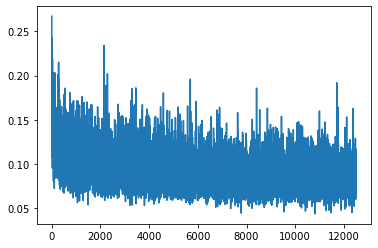

In [12]:
# have a quick look at the training curve of the Noise2Noise algorithm
real_loss = []
for loss in losses:
    real_loss.append(loss.item())
plt.plot(real_loss)

Text(0.5, 1.0, 'model output')

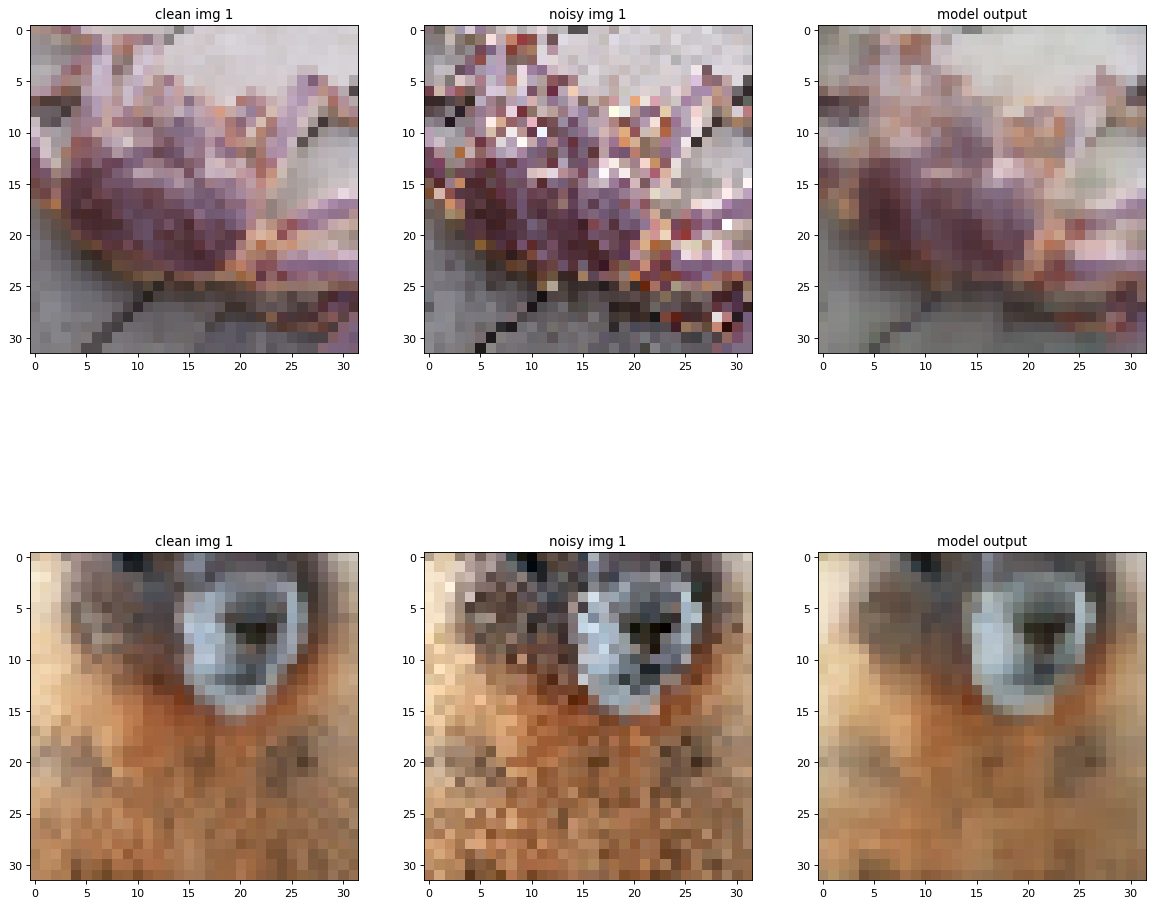

In [13]:
# let us use the model to see it's effect by loading individual images, and using the model to see it's output on several images
torch.cuda.empty_cache()
plt.figure(figsize=(18, 16), dpi=80)
noisy_imgs_1 = noisy_imgs_1.to('cuda')
noisy_imgs_2 = noisy_imgs_2.to('cuda')
noisy_imgs, clean_imgs = noisy_imgs.to('cuda'), clean_imgs.to('cuda')
output = model(noisy_imgs[0:5,:,:,:]); 

noisy_imgs_1 = noisy_imgs_1.to('cpu')
noisy_imgs_2 = noisy_imgs_2.to('cpu')
noisy_imgs, clean_imgs = noisy_imgs.to('cpu'), clean_imgs.to('cpu')
output = output.to('cpu')

plt.subplot(2,3,1)
plt.imshow(clean_imgs[0].permute(1, 2, 0));plt.title('clean img 1')
plt.subplot(2,3,2)
plt.imshow(noisy_imgs[0].permute(1, 2, 0));plt.title('noisy img 1')
plt.subplot(2,3,3)
x = output[0].permute(1, 2, 0);
plt.imshow(x.detach().numpy());plt.title('model output')

plt.subplot(2,3,4)
plt.imshow(clean_imgs[1].permute(1, 2, 0));plt.title('clean img 1')
plt.subplot(2,3,5)
plt.imshow(noisy_imgs[1].permute(1, 2, 0));plt.title('noisy img 1')
plt.subplot(2,3,6)
x = output[1].permute(1, 2, 0);
plt.imshow(x.detach().numpy());plt.title('model output')

In [12]:
# compute the PSNR, increased heavily !
PSNR = torch.zeros([1000,1])
for i in range(1000):
    y = clean_imgs[i].permute(1, 2, 0)
    x = output_img[i,:,:,:].permute(1, 2, 0)
    PSNR[i,0] = psnr(x,y)
print('validation PSNR = ', PSNR.mean())

validation PSNR =  tensor(24.2978, grad_fn=<MeanBackward0>)


Text(0, 0.5, 'number of images')

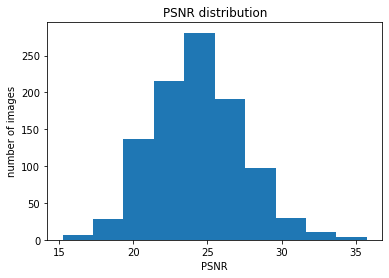

In [13]:
# plot the PSNR for all our images
plt.hist(PSNR.detach().numpy())
plt.title('PSNR distribution')
plt.xlabel('PSNR')
plt.ylabel('number of images')